In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torchvision.models as models
from tqdm import tqdm
# import seaborn as sns

In [2]:
df_train = pd.read_csv('../../data/classify-leaves/train.csv')
df_test = pd.read_csv('../../data/classify-leaves/test.csv')
df_train.head()

,image,label
0,images/0.jpg,maclura_pomifera
1,images/1.jpg,maclura_pomifera
2,images/2.jpg,maclura_pomifera
3,images/3.jpg,maclura_pomifera
4,images/4.jpg,maclura_pomifera


In [3]:
df_train.describe()

,image,label
count,18353,18353
unique,18353,176
top,images/4689.jpg,maclura_pomifera
freq,1,353


In [4]:
df_test.describe()

,image
count,8800
unique,8800
top,images/25208.jpg
freq,1


In [5]:
# 把label中的类别转换为数字
class_to_num = {label:idx for idx, label in enumerate(sorted(df_train.label.unique()))}
class_to_num

{'abies_concolor': 0,
 'abies_nordmanniana': 1,
 'acer_campestre': 2,
 'acer_ginnala': 3,
 'acer_griseum': 4,
 'acer_negundo': 5,
 'acer_palmatum': 6,
 'acer_pensylvanicum': 7,
 'acer_platanoides': 8,
 'acer_pseudoplatanus': 9,
 'acer_rubrum': 10,
 'acer_saccharinum': 11,
 'acer_saccharum': 12,
 'aesculus_flava': 13,
 'aesculus_glabra': 14,
 'aesculus_hippocastamon': 15,
 'aesculus_pavi': 16,
 'ailanthus_altissima': 17,
 'albizia_julibrissin': 18,
 'amelanchier_arborea': 19,
 'amelanchier_canadensis': 20,
 'amelanchier_laevis': 21,
 'asimina_triloba': 22,
 'betula_alleghaniensis': 23,
 'betula_jacqemontii': 24,
 'betula_lenta': 25,
 'betula_nigra': 26,
 'betula_populifolia': 27,
 'broussonettia_papyrifera': 28,
 'carpinus_betulus': 29,
 'carpinus_caroliniana': 30,
 'carya_cordiformis': 31,
 'carya_glabra': 32,
 'carya_ovata': 33,
 'carya_tomentosa': 34,
 'castanea_dentata': 35,
 'catalpa_bignonioides': 36,
 'catalpa_speciosa': 37,
 'cedrus_atlantica': 38,
 'cedrus_deodara': 39,
 'cedru

In [6]:
# 在翻转回去，把数字转换为label
num_to_class = {idx:label for label, idx in class_to_num.items()}
num_to_class

{0: 'abies_concolor',
 1: 'abies_nordmanniana',
 2: 'acer_campestre',
 3: 'acer_ginnala',
 4: 'acer_griseum',
 5: 'acer_negundo',
 6: 'acer_palmatum',
 7: 'acer_pensylvanicum',
 8: 'acer_platanoides',
 9: 'acer_pseudoplatanus',
 10: 'acer_rubrum',
 11: 'acer_saccharinum',
 12: 'acer_saccharum',
 13: 'aesculus_flava',
 14: 'aesculus_glabra',
 15: 'aesculus_hippocastamon',
 16: 'aesculus_pavi',
 17: 'ailanthus_altissima',
 18: 'albizia_julibrissin',
 19: 'amelanchier_arborea',
 20: 'amelanchier_canadensis',
 21: 'amelanchier_laevis',
 22: 'asimina_triloba',
 23: 'betula_alleghaniensis',
 24: 'betula_jacqemontii',
 25: 'betula_lenta',
 26: 'betula_nigra',
 27: 'betula_populifolia',
 28: 'broussonettia_papyrifera',
 29: 'carpinus_betulus',
 30: 'carpinus_caroliniana',
 31: 'carya_cordiformis',
 32: 'carya_glabra',
 33: 'carya_ovata',
 34: 'carya_tomentosa',
 35: 'castanea_dentata',
 36: 'catalpa_bignonioides',
 37: 'catalpa_speciosa',
 38: 'cedrus_atlantica',
 39: 'cedrus_deodara',
 40: 'c

In [12]:
# 创建自己的数据集，继承Dataset类
class LeavesData(Dataset):
    def __init__(self, csv_path, file_path, mode='train', valid_rate=0.2, resize_hight=224, resize_width=224, transform=None):
        self.resize_hight = resize_hight
        self.resize_width = resize_width
        self.csv_path = csv_path
        self.file_path = file_path
        self.mode = mode
        # 开始读取csv文件
        self.data_info = pd.read_csv(csv_path, header=None)
        # 数组中的元素是从0开始的，所以要减1
        self.data_len = len(self.data_info.index) - 1
        self.train_len = int(self.data_len * (1 - valid_rate))

        if mode=='train':
            # 我觉得这里应该从下标从0开始，而不是1开始，等会再来看
            self.train_image = np.asarray(self.data_info.iloc[1:self.train_len, 0])
            self.train_label = np.asarray(self.data_info.iloc[1:self.train_len, 1])
            self.image_arr = self.train_image
            self.label_arr = self.train_label
        elif mode=='valid':
            self.valid_image = np.asarray(self.data_info.iloc[self.train_len:, 0])
            self.valid_label = np.asarray(self.data_info.iloc[self.train_len:, 1])
            self.image_arr = self.valid_image
            self.label_arr = self.valid_label
        elif mode=='test':
            self.test_image = np.asarray(self.data_info.iloc[1:, 0])
            self.image_arr = self.test_image
        self.real_len = len(self.image_arr)
        print('{} data: {}'.format(mode, self.real_len))
    def __getitem__(self, index):
        single_image_name = self.image_arr[index]
        img_as_img = Image.open(self.file_path + single_image_name)
        if self.mode=='train':
            # 只有train数据集的时候才做数据增强
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(0.5),
                transforms.ToTensor()
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ])
        img_as_img = transform(img_as_img)
        if self.mode=='test':
            return img_as_img
        else:
            label = self.label_arr[index]
            number_label = class_to_num[label]
            return img_as_img, number_label
    def __len__(self):
        return self.real_len 

In [13]:
train_path = '../../data/classify-leaves/train.csv'
test_path = '../../data/classify-leaves/test.csv'
# csv文件中已经images的路径了，因此这里只到上一级目录
img_path = '../../data/classify-leaves/'

train_dataset = LeavesData(train_path, img_path, mode='train')
val_dataset = LeavesData(train_path, img_path, mode='valid')
test_dataset = LeavesData(test_path, img_path, mode='test')
print(train_dataset)
print(val_dataset)
print(test_dataset)

train data: 14681
valid data: 3672
test data: 8800


In [14]:
# 定义data loader
train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=8, 
        shuffle=False,
        num_workers=5
    )

val_loader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=8, 
        shuffle=False,
        num_workers=5
    )
test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=8, 
        shuffle=False,
        num_workers=5
    )

/home/y/.conda/envs/pytorch/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


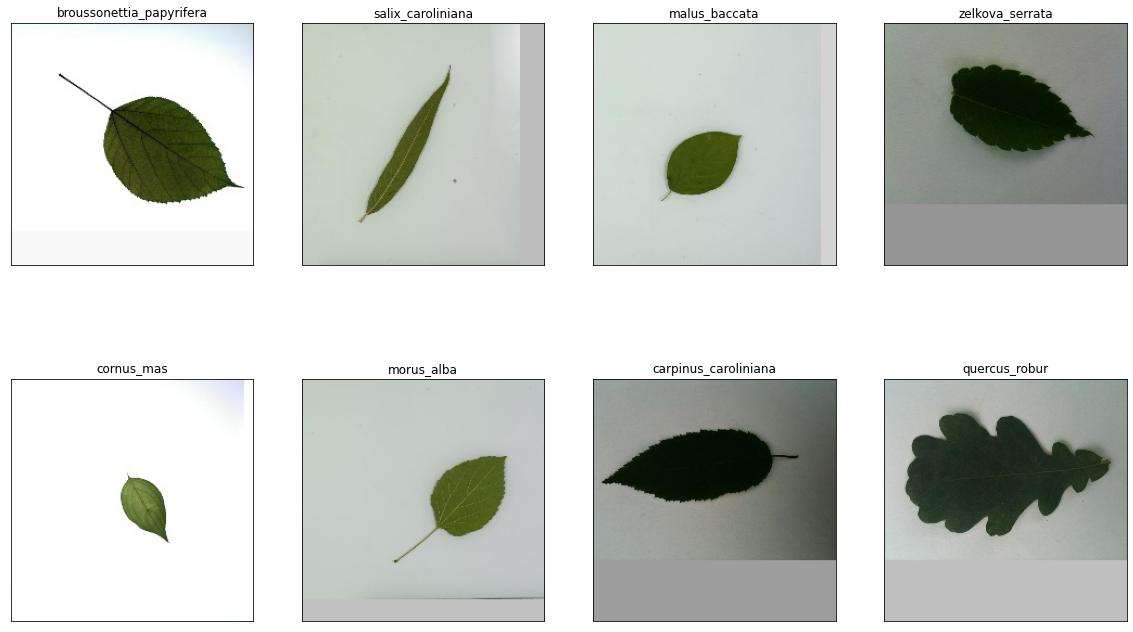

In [15]:
# 给大家展示一下数据长啥样
def im_convert(tensor):
    """ 展示数据"""
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image.clip(0, 1)

    return image

fig=plt.figure(figsize=(20, 12))
columns = 4
rows = 2

dataiter = iter(val_loader)
inputs, classes = dataiter.next()

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    ax.set_title(num_to_class[int(classes[idx])])
    plt.imshow(im_convert(inputs[idx]))
plt.show()